<a href="https://colab.research.google.com/github/duc-ke/DNN_CV_complete_guide/blob/main/st03/mm_faster_rcnn_train_kitti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## kitti 데이터셋을 이용하여 faster R-CNN을 학습
* 커스텀데이터로 학습하여 모델 생성해보는 경험 w/MMDetection
* 고양이 kitty아님. 무인 자동차를 위한 테스트 데이터

In [1]:
# https://github.com/open-mmlab/mmdetection/blob/master/demo/MMDet_Tutorial.ipynb 에서 발췌

In [2]:
import torch
torch.__version__

'1.11.0+cu113'

In [3]:
# mmcv를 위해서 mmcv-full을 먼저 설치해야 함. https://mmcv.readthedocs.io/en/latest/get_started/installation.html 설치 과정 참조.
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu113/torch1.11.0/index.html
# mmdetection 설치 
!git clone https://github.com/open-mmlab/mmdetection.git
!cd mmdetection; python setup.py install

Looking in links: https://download.openmmlab.com/mmcv/dist/cu113/torch1.11.0/index.html
     |████████████████████████████████| 37.5 MB 9.9 MB/s 
     |████████████████████████████████| 190 kB 5.0 MB/s 
Cloning into 'mmdetection'...
remote: Enumerating objects: 24334, done.
remote: Total 24334 (delta 0), reused 0 (delta 0), pack-reused 24334
Receiving objects: 100% (24334/24334), 37.47 MiB | 27.75 MiB/s, done.
Resolving deltas: 100% (17035/17035), done.
running install
running bdist_egg
running egg_info
creating mmdet.egg-info
writing mmdet.egg-info/PKG-INFO
writing dependency_links to mmdet.egg-info/dependency_links.txt
writing requirements to mmdet.egg-info/requires.txt
writing top-level names to mmdet.egg-info/top_level.txt
writing manifest file 'mmdet.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
adding license file 'LICENSE'
writing manifest file 'mmdet.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_p

In [26]:
# 아래를 수행하기 전에 kernel을 restart 해야 함. (런타임 다시 시작)
from mmdet.apis import init_detector, inference_detector
import mmcv

### KITTI Dataset 다운로드
* 작은 용량의 KITTI Dataset을 다운로드하고 /content 밑에 압축 해제
* 원래 kitti directory 구조완 다름.
* 다운로드 받으면 Pascal voc처럼 annotation이 이미지 마다 만들어져있음.
* annotation : 공백으로 분리

In [27]:
# mmdetection의 튜토리얼용 데이터셋 (원본은 엄청 크다.)
!wget https://download.openmmlab.com/mmdetection/data/kitti_tiny.zip
!unzip kitti_tiny.zip > /dev/null

--2022-05-05 10:35:45--  https://download.openmmlab.com/mmdetection/data/kitti_tiny.zip
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.28
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6918271 (6.6M) [application/zip]
Saving to: ‘kitti_tiny.zip.1’

kitti_tiny.zip.1    100%[===================>]   6.60M  3.29MB/s    in 2.0s    

2022-05-05 10:35:48 (3.29 MB/s) - ‘kitti_tiny.zip.1’ saved [6918271/6918271]

replace kitti_tiny/val.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

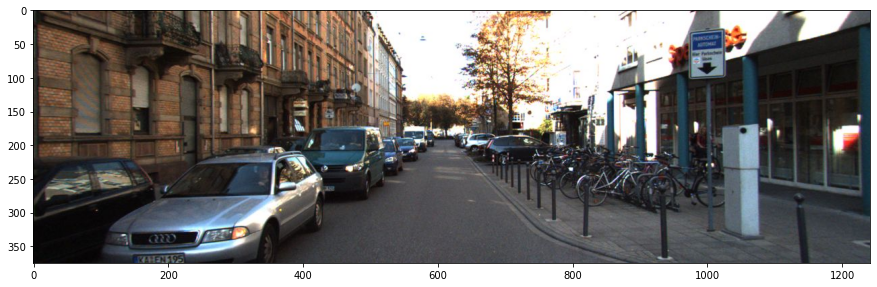

In [28]:
import matplotlib.pyplot as plt
import cv2

img = cv2.cvtColor(cv2.imread('/content/kitti_tiny/training/image_2/000068.jpeg'), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15, 10))
plt.imshow(img)

### KITTI DATA FORMAT 확인
* 첫번째 컬럼은 해당 오브젝트의 클래스 명. 
* 5번째~8번째가 BOUNDING BOX 정보임. 좌상단(xmin, ymin), 우하단(xmax, ymax) 좌표 임. 

In [29]:
!cat /content/kitti_tiny/training/label_2/000068.txt

Car 0.25 0 1.94 69.26 200.28 435.08 374.00 1.46 1.62 4.04 -3.00 1.79 6.98 1.55
Car 0.80 1 2.26 0.00 209.20 198.59 374.00 1.46 1.58 3.72 -5.44 1.85 6.22 1.56
Cyclist 0.97 0 2.34 1210.28 199.77 1241.00 374.00 1.55 0.57 1.73 4.04 1.69 3.57 -3.14
Car 0.00 2 1.68 478.18 187.68 549.54 249.43 1.57 1.60 3.99 -2.73 2.03 20.96 1.55
Car 0.00 1 1.66 530.03 187.79 573.10 226.09 1.52 1.54 3.68 -2.53 2.20 31.50 1.58
Van 0.00 1 1.63 547.61 171.12 584.05 212.41 2.47 1.98 5.81 -2.79 2.41 46.44 1.57
Car 0.00 1 -0.16 667.74 182.35 790.82 230.38 1.62 1.65 4.14 4.19 1.99 25.95 0.00
Car 0.00 2 -0.11 657.37 184.48 763.34 221.64 1.55 1.66 4.47 4.35 2.10 32.00 0.02
Car 0.00 1 -0.01 637.45 180.34 714.44 212.34 1.69 1.76 4.12 3.59 2.12 39.79 0.08
Van 0.00 1 1.61 572.52 175.02 596.26 199.95 2.13 1.91 6.40 -2.28 2.36 65.43 1.57
Van 0.00 1 1.77 380.78 167.69 523.29 288.56 1.95 1.75 4.63 -2.89 1.90 14.05 1.57
Cyclist 0.00 1 1.09 958.95 167.55 1036.88 254.43 1.68 0.53 1.96 7.95 1.59 14.95 1.57


### KITTI annotation 파일들의 리스트들을 가지는 파일 확인. 
* 확장자 빠진 파일 고유 name(id)가 있음.

In [30]:
!cat /content/kitti_tiny/train.txt

000000
000001
000002
000003
000004
000005
000006
000007
000008
000009
000010
000011
000012
000013
000014
000015
000016
000017
000018
000019
000020
000021
000022
000023
000024
000025
000026
000027
000028
000029
000030
000031
000032
000033
000034
000035
000036
000037
000038
000039
000040
000041
000042
000043
000044
000045
000046
000047
000048
000049


### mmdetection의 중립 annotation 포맷 변환(middle format). 해당 포맷은 텍스트로 변환하지 않음. 바로 메모리 상의 list로 생성됨.  
#### filename, width, height, ann을 Key로 가지는 Dictionary를 이미지 개수대로 가지는 list 생성. 
* filename: 이미지 파일명(디렉토리는 포함하지 않음)
* width: 이미지 너비
* height: 이미지 높이
* ann: bbounding box와 label에 대한 정보를 가지는 Dictionary
 - bboxes: 하나의 이미지에 있는 여러 Object 들의 numpy array. 4개의 좌표값(좌상단, 우하단)을 가지고, 해당 이미지에 n개의 Object들이 있을 경우 array의 shape는 (n, 4)
 - labels: 하나의 이미지에 있는 여러 Object들의 numpy array. shape는 (n, )
 - bboxes_ignore: 학습에 사용되지 않고 무시하는 bboxes. 무시하는 bboxes의 개수가 k개이면 shape는 (k, 4)
 - labels_ignore: 학습에 사용되지 않고 무시하는 labels. 무시하는 bboxes의 개수가 k개이면 shape는 (k,)



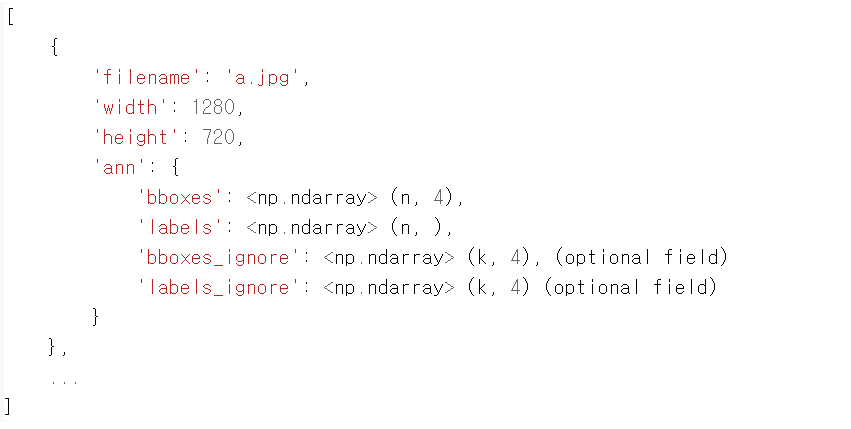

# middle format 정리.
```python
[
 {
    'filename': 'a.jpg', 
    'width': 300, 'height': 200, 
    'ann' : {
        'bboxes': <np.array> (n, 4),
        'labels': <np.array> (n, ),
        'bboxes_ignore': <np.array> (k, 4),
        'labels_ignore': <np.array> (k, 4)
    }
 }
]
```

### kitti Dataset을 중립 데이터형태로 변환하여 메모리 로드

In [31]:
# 원본 kitti Dataset는 10개의 Class로 되어 있음. 'Car Van Truck Pedestrian Person_sitting Cyclist Tram Misc DontCare'
CLASSES = ('Car', 'Truck', 'Pedestrian', 'Cyclist')
cat2label = {k:i for i, k in enumerate(CLASSES)}
print(cat2label)
cat2label['Car']


{'Car': 0, 'Truck': 1, 'Pedestrian': 2, 'Cyclist': 3}


0

In [32]:
# mmcv.list_from_file()의 역할을 알아본다 : 파일 읽어서 리스트로 반환
# 이미지의 basename이자 annotation의 basename이기도 하다.
image_list = mmcv.list_from_file('/content/kitti_tiny/train.txt')
image_list

['000000',
 '000001',
 '000002',
 '000003',
 '000004',
 '000005',
 '000006',
 '000007',
 '000008',
 '000009',
 '000010',
 '000011',
 '000012',
 '000013',
 '000014',
 '000015',
 '000016',
 '000017',
 '000018',
 '000019',
 '000020',
 '000021',
 '000022',
 '000023',
 '000024',
 '000025',
 '000026',
 '000027',
 '000028',
 '000029',
 '000030',
 '000031',
 '000032',
 '000033',
 '000034',
 '000035',
 '000036',
 '000037',
 '000038',
 '000039',
 '000040',
 '000041',
 '000042',
 '000043',
 '000044',
 '000045',
 '000046',
 '000047',
 '000048',
 '000049']

In [33]:
lines = mmcv.list_from_file('/content/kitti_tiny/training/label_2/000064.txt')
#print(lines)
content = [line.strip().split(' ') for line in lines]
bbox_names = [x[0] for x in content]
#print(bbox_names)
bboxes = [ [float(info) for info in x[4:8]] for x in content]
print(bbox_names)
print(bboxes)

['Car', 'Car', 'Car', 'Truck', 'DontCare', 'DontCare']
[[657.65, 179.93, 709.86, 219.92], [731.51, 180.39, 882.28, 275.8], [715.18, 175.63, 762.77, 203.9], [816.58, 59.74, 1112.51, 266.07], [626.78, 174.27, 647.77, 192.18], [546.19, 168.97, 554.01, 177.09]]


In [34]:
import copy
import os.path as osp
import cv2

import mmcv
import numpy as np

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

# @는 데코레이터 : 프레임워크에 등록.
# 반드시 아래 Decorator 설정 할것.@DATASETS.register_module() 설정 시 force=True를 입력하지 않으면 Dataset 재등록 불가. 
@DATASETS.register_module(force=True)
class KittyTinyDataset(CustomDataset):  # 상속
  CLASSES = ('Car', 'Truck', 'Pedestrian', 'Cyclist') # CLASSES 속성(변수) 필수!

  ## def __init__() 없음. CutomDataset의 init을 그대로 쓴다는 것임.
  

  ##### self.data_root: /content/kitti_tiny/ self.ann_file: /content/kitti_tiny/train.txt self.img_prefix: /content/kitti_tiny/training/image_2
  #### ann_file: /content/kitti_tiny/train.txt
  # 아래 셀에서 img_prefix는 training/image_2 만 넣어줬는데 내부적으로 dataroot와 concat됨. (CustomDatset의 init에서 작동함)
  # annotation에 대한 모든 파일명을 가지고 있는 텍스트 파일을 __init__(self, ann_file)로 입력 받고, 이 self.ann_file이 load_annotations()의 인자로 입력
  # ann_file(train.txt 또는 val.txt)은 이미지 basename만 가지고 있었는데 이걸로 load_annotation() 함수를 구성한다.
  def load_annotations(self, ann_file):
    print('##### self.data_root:', self.data_root, 'self.ann_file:', self.ann_file, 'self.img_prefix:', self.img_prefix)
    print('#### ann_file:', ann_file)
    cat2label = {k:i for i, k in enumerate(self.CLASSES)}
    image_list = mmcv.list_from_file(self.ann_file)  # 파일 읽어서 리스트로 만들어줌. 파일 basename의 리스트.
    # 포맷 중립(middle format) 데이터를 담을 list 객체
    data_infos = []
    
    for image_id in image_list:  # train.txt에 있던 각 basename
      filename = '{0:}/{1:}.jpeg'.format(self.img_prefix, image_id) # img_prefix : /content/kitti_tiny/training/image_2
      # 원본 이미지의 너비, 높이를 image를 직접 로드하여 구함. 
      image = cv2.imread(filename)
      height, width = image.shape[:2]
      # 개별 image의 annotation 정보 저장용 Dict 생성. key값 filename 에는 image의 파일명만 들어감(디렉토리는 제외)
      data_info = {'filename': str(image_id) + '.jpeg',
                   'width': width, 'height': height}
      # 개별 annotation이 있는 서브 디렉토리의 prefix 변환. 
      # self.img_prefix: /content/kitti_tiny/training/image_2
      label_prefix = self.img_prefix.replace('image_2', 'label_2')
      # 개별 annotation 파일을 1개 line 씩 읽어서 list 로드  (class, bbox ccorniates가 들어있음)
      lines = mmcv.list_from_file(osp.join(label_prefix, str(image_id)+'.txt'))

      # 전체 lines를 개별 line별 공백 레벨로 parsing 하여 다시 list로 저장. content는 list의 list형태임.
      # ann 정보는 numpy array로 저장되나 텍스트 처리나 데이터 가공이 list 가 편하므로 일차적으로 list로 변환 수행.   
      # 2차원 리스트임
      content = [line.strip().split(' ') for line in lines]
      # 오브젝트의 클래스명은 bbox_names로 저장. 
      bbox_names = [x[0] for x in content]  # x는 annotation 각 라인에 대한 리스트임
      # bbox 좌표를 저장 (2차원 리스트 [[100, 140, 200, 250], [...] ... ])
      bboxes = [ [float(info) for info in x[4:8]] for x in content]

      # 클래스명이 해당 사항이 없는 대상 Filtering out, 'DontCare'sms ignore로 별도 저장.
      gt_bboxes = []
      gt_labels = []
      gt_bboxes_ignore = []
      gt_labels_ignore = []

      ## middle format의 'ann'파트를 채운다.
      for bbox_name, bbox in zip(bbox_names, bboxes):
        # 위에서 CLASSES 변수에 지정된 클래스가 아닌거면 걸러줌.
        # 만약 bbox_name이 클래스명에 해당 되면, gt_bboxes와 gt_labels에 추가, 그렇지 않으면 gt_bboxes_ignore, gt_labels_ignore에 추가
        if bbox_name in cat2label:
          gt_bboxes.append(bbox)
          # gt_labels에는 class id를 입력(클래스 이름이 아닌 idx가 들어감)
          gt_labels.append(cat2label[bbox_name])
        else:
          gt_bboxes_ignore.append(bbox)
          gt_labels_ignore.append(-1)  # idx는 -1
      # 개별 image별 annotation 정보를 가지는 Dict 생성. 해당 Dict의 value값은 모두 np.array임. 
      data_anno = {
          'bboxes': np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4), # 2차원 리스트
          'labels': np.array(gt_labels, dtype=np.long),
          'bboxes_ignore': np.array(gt_bboxes_ignore, dtype=np.float32).reshape(-1, 4),
          'labels_ignore': np.array(gt_labels_ignore, dtype=np.long)
      }

      ## data_info는 dict, data_infos는 리스트이다.
      # image에 대한 메타 정보를 가지는 data_info Dict에 'ann' key값으로 data_anno를 value로 저장. 
      data_info.update(ann=data_anno)
      # 전체 annotation 파일들에 대한 정보를 가지는 data_infos에 data_info Dict를 추가
      data_infos.append(data_info)

    return data_infos   # 결국 이건 middle format : 리스트 [{}, {} .. ] 이다.


In [35]:
### Config 설정하고 Pretrained 모델 다운로드
# inference 와 동일함
config_file = '/content/mmdetection/configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py'
checkpoint_file = '/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

In [36]:
!cd mmdetection; mkdir checkpoints
!wget -O /content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth

mkdir: cannot create directory ‘checkpoints’: File exists
--2022-05-05 10:37:40--  http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.28
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167287506 (160M) [application/octet-stream]
Saving to: ‘/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth’

/content/mmdetectio 100%[===================>] 159.54M  9.06MB/s    in 18s     

2022-05-05 10:38:00 (8.77 MB/s) - ‘/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth’ saved [167287506/167287506]



In [37]:
from mmcv import Config

# 기본적인 config 파일을 읽는다.
cfg = Config.fromfile(config_file)
print(cfg.pretty_text)

model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.

## config에 데이터셋정보를 내가 가진 환경에 맞도록 업데이트 한다.

In [51]:
from mmdet.apis import set_random_seed

# dataset에 대한 환경 파라미터 수정. 
cfg.dataset_type = 'KittyTinyDataset'  # 내가 만든 class 명으로 교체
cfg.data_root = '/content/kitti_tiny/' # 절대경로 추천

# train, val, test dataset에 대한 type, data_root, ann_file, img_prefix 환경 파라미터 수정. 
cfg.data.train.type = 'KittyTinyDataset'
cfg.data.train.data_root = '/content/kitti_tiny/'   # dir
cfg.data.train.ann_file = 'train.txt'              # file 한개 (사실 annotation은 아님. 그러나 파일 한개만 받아야 하니 이걸 넘겨서 class에서 직접 컨트롤 할수 있도록 변경)
cfg.data.train.img_prefix = 'training/image_2'      # dir (/를 넣으면 안됨. 절대경로가 되어버림.)

# validation은 내부적으로 알아서 찾음.
cfg.data.val.type = 'KittyTinyDataset'
cfg.data.val.data_root = '/content/kitti_tiny/'
cfg.data.val.ann_file = 'val.txt'
cfg.data.val.img_prefix = 'training/image_2'

cfg.data.test.type = 'KittyTinyDataset'
cfg.data.test.data_root = '/content/kitti_tiny/'
cfg.data.test.ann_file = 'val.txt'
cfg.data.test.img_prefix = 'training/image_2'

# class의 갯수 수정. 
cfg.model.roi_head.bbox_head.num_classes = 4
# pretrained 모델 (상대경로임)
cfg.load_from = 'checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'  # 상대경로로 (/centent/mmdtect/ 가 현 디렉토리)

# 학습 weight 파일로 로그를 저장하기 위한 디렉토리 설정. 
cfg.work_dir = './tutorial_exps'

# 학습율 변경 환경 파라미터 설정. 
cfg.optimizer.lr = 0.02 / 8

## warmup 바로 낮추지 않고 천천히 낮추는것
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# config 수행 시마다 policy값이 없어지는 bug로 인하여 설정. 
# policy : learning rate scheduler.
# 'step' lr낮출때 계단식으로 낮추는 방법!!!!
# 'cyclic', 'cosinealing' 등등이 있다. 찾아보자. 
cfg.lr_config.policy = 'step'

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 12
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

## [기타 정보]
"""
cfg.train_pipeline : transform 정보들
cfg.img_norm_cfg : normalization 방법(평균, std정의)
cfg.optimizer.type : optimizer 종류 설정 ('ADAM')
cfg.runner.max_epochs : epoch정의
"""

# 'ConfigDict' object has no attribute 'device' 오류 방지를 위한 설정. 
cfg.device='cuda'

# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_w

In [ ]:
# from mmdet.apis import set_random_seed

# # dataset에 대한 환경 파라미터 수정. 
# cfg.dataset_type = 'KittyTinyDataset'
# cfg.data_root = '/content/kitti_tiny/'

# # train, val, test dataset에 대한 type, data_root, ann_file, img_prefix 환경 파라미터 수정. 
# cfg.data.train.type = 'KittyTinyDataset'
# cfg.data.train.data_root = '/content/kitti_tiny/'
# cfg.data.train.ann_file = 'train.txt'
# cfg.data.train.img_prefix = 'training/image_2'

# cfg.data.val.type = 'KittyTinyDataset'
# cfg.data.val.data_root = '/content/kitti_tiny/'
# cfg.data.val.ann_file = 'val.txt'
# cfg.data.val.img_prefix = 'training/image_2'

# cfg.data.test.type = 'KittyTinyDataset'
# cfg.data.test.data_root = '/content/kitti_tiny/'
# cfg.data.test.ann_file = 'val.txt'
# cfg.data.test.img_prefix = 'training/image_2'

# # class의 갯수 수정. 
# cfg.model.roi_head.bbox_head.num_classes = 4
# # pretrained 모델
# cfg.load_from = 'checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

# # 학습 weight 파일로 로그를 저장하기 위한 디렉토리 설정. 
# cfg.work_dir = './tutorial_exps'

# # 학습율 변경 환경 파라미터 설정. 
# cfg.optimizer.lr = 0.02 / 8

# cfg.lr_config.warmup = None
# cfg.log_config.interval = 10

# # config 수행 시마다 policy값이 없어지는 bug로 인하여 설정. 
# cfg.lr_config.policy = 'step'

# # Change the evaluation metric since we use customized dataset.
# cfg.evaluation.metric = 'mAP'
# # We can set the evaluation interval to reduce the evaluation times
# cfg.evaluation.interval = 12
# # We can set the checkpoint saving interval to reduce the storage cost
# cfg.checkpoint_config.interval = 12

# cfg.data.train.pipeline=[
#             dict(type='LoadImageFromFile'),
#             dict(type='LoadAnnotations', with_bbox=True),
#             dict(type='Resize', img_scale=(1500, 900), keep_ratio=True),
#             dict(type='RandomFlip', flip_ratio=0.5),
#             dict(
#                 type='Normalize',
#                 mean=[123.675, 116.28, 103.53],
#                 std=[58.395, 57.12, 57.375],
#                 to_rgb=True),
#             dict(type='Pad', size_divisor=32),
#             dict(type='DefaultFormatBundle'),
#             dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels'])
#         ]

# cfg.data.val.pipeline=[
#             dict(type='LoadImageFromFile'),
#             dict(
#                 type='MultiScaleFlipAug',
#                 img_scale=(1500, 900),
#                 flip=False,
#                 transforms=[
#                     dict(type='Resize', keep_ratio=True),
#                     dict(type='RandomFlip'),
#                     dict(
#                         type='Normalize',
#                         mean=[123.675, 116.28, 103.53],
#                         std=[58.395, 57.12, 57.375],
#                         to_rgb=True),
#                     dict(type='Pad', size_divisor=32),
#                     dict(type='ImageToTensor', keys=['img']),
#                     dict(type='Collect', keys=['img'])
#                 ])
#         ]
  
# cfg.train_pipeline = [
#     dict(type='LoadImageFromFile'),
#     dict(type='LoadAnnotations', with_bbox=True),
#     dict(type='Resize', img_scale=(1500, 900), keep_ratio=True),
#     dict(type='RandomFlip', flip_ratio=0.5),
#     dict(
#         type='Normalize',
#         mean=[123.675, 116.28, 103.53],
#         std=[58.395, 57.12, 57.375],
#         to_rgb=True),
#     dict(type='Pad', size_divisor=32),
#     dict(type='DefaultFormatBundle'),
#     dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels'])
# ]
# cfg.test_pipeline = [
#     dict(type='LoadImageFromFile'),
#     dict(
#         type='MultiScaleFlipAug',
#         img_scale=(1500, 900),
#         flip=False,
#         transforms=[
#             dict(type='Resize', keep_ratio=True),
#             dict(type='RandomFlip'),
#             dict(
#                 type='Normalize',
#                 mean=[123.675, 116.28, 103.53],
#                 std=[58.395, 57.12, 57.375],
#                 to_rgb=True),
#             dict(type='Pad', size_divisor=32),
#             dict(type='ImageToTensor', keys=['img']),
#             dict(type='Collect', keys=['img'])
#         ])
# ]
# # Set seed thus the results are more reproducible
# cfg.seed = 0
# set_random_seed(0, deterministic=False)
# cfg.gpu_ids = range(1)


# # We can initialize the logger for training and have a look
# # at the final config used for training
# # config를 모두 출력해본다. config는 모두 dictionary이며 . 으로 이동가능하다.
# print(f'Config:\n{cfg.pretty_text}')

config는 모두 dictionary이며 . 으로 이동가능하다.

### Config에서 설정한 Dataset과 Model, 동적 학습율, Pipeline 설정에 따라 모델 학습 수행. 

* train용 Dataset을 생성하고 이를 이용하여 학습 수행. 

In [52]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

# train용 Dataset 생성. (이때 드디어 데이터셋이 생성)
# 데이터 셋은 cfg.data.train config를 받아서 만듦.
datasets = [build_dataset(cfg.data.train)]

##### self.data_root: /content/kitti_tiny/ self.ann_file: /content/kitti_tiny/train.txt self.img_prefix: /content/kitti_tiny/training/image_2
#### ann_file: /content/kitti_tiny/train.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int`

In [53]:
datasets

[
 KittyTinyDataset Train dataset with number of images 50, and instance counts: 
 +----------+-------+-----------+-------+----------------+-------+-------------+-------+---------------+-------+
 | category | count | category  | count | category       | count | category    | count | category      | count |
 +----------+-------+-----------+-------+----------------+-------+-------------+-------+---------------+-------+
 | 0 [Car]  | 147   | 1 [Truck] | 7     | 2 [Pedestrian] | 23    | 3 [Cyclist] | 7     | -1 background | 0     |
 +----------+-------+-----------+-------+----------------+-------+-------------+-------+---------------+-------+]

이미지가 50개. 이 안에 전체 obj를 보여 준다.
kitti에 트럭은 있어도 cyclist는 아예없기 때문에, 데이터 수가 7개니까 성능 기대 어렵다.

In [54]:
datasets[0].CLASSES

('Car', 'Truck', 'Pedestrian', 'Cyclist')

In [55]:
model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
model.CLASSES = datasets[0].CLASSES

In [56]:
# 주의, config에 pretrained 모델 지정이 상대 경로로 설정됨 cfg.load_from = 'checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'
# 아래와 같이 %cd mmdetection 지정 필요. 
 
%cd mmdetection 

# weight 저장 경로 설정
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
# epochs는 config의 runner 파라미터로 지정됨. 기본 12회 
# validate=T : validation set을 찾아서 validation진행
train_detector(model, datasets, cfg, distributed=False, validate=True)

[Errno 2] No such file or directory: 'mmdetection'
/content/mmdetection


2022-05-05 11:00:58,997 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by i

##### self.data_root: /content/kitti_tiny/ self.ann_file: /content/kitti_tiny/val.txt self.img_prefix: /content/kitti_tiny/training/image_2
#### ann_file: /content/kitti_tiny/val.txt


2022-05-05 11:00:59,288 - mmdet - INFO - load checkpoint from local path: checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
2022-05-05 11:00:59,464 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([5, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([5]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([16, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([16]).
2022-05-05 11:00:59,470 - mmdet - INFO - Start running, host: root@1d1064569390, work_dir: /content/mm

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 25/25, 3.6 task/s, elapsed: 7s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-05-05 11:07:44,199 - mmdet - INFO - 
+------------+-----+------+--------+-------+
| class      | gts | dets | recall | ap    |
+------------+-----+------+--------+-------+
| Car        | 62  | 144  | 0.968  | 0.839 |
| Truck      | 3   | 21   | 1.000  | 0.500 |
| Pedestrian | 13  | 46   | 0.846  | 0.730 |
| Cyclist    | 7   | 48   | 0.429  | 0.061 |
+------------+-----+------+--------+-------+
| mAP        |     |      |        | 0.533 |
+------------+-----+------+--------+-------+
2022-05-05 11:07:44,202 - mmdet - INFO - Epoch(val) [12][25]	AP50: 0.5330, mAP: 0.5327


In [58]:
!nvidia-smi

Thu May  5 11:07:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    57W / 149W |   3307MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

IOU로 evaluation을 해서 클래스 별로 AP를 계산한다.
* cyclist : 데이터셋도 별로없고 pretrained model(coco)에서도 없었기 때문

강의와는 달리 생각보다 학습 오래걸림(5분 넘은 듯) - Tesla K80 때문인듯함.

### 학습된 model(메모리에 로드된 모델)을 이용하여 inference 수행. 

In [2]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

# BGR Image 사용 
img = cv2.imread('/content/kitti_tiny/training/image_2/000068.jpeg')

# 업데이트
model.cfg = cfg

# BGR inference
result = inference_detector(model, img)
show_result_pyplot(model, img, result)

NameError: ignored

# 학습 완료 후 저장된 모델로 부터 inference를 해보자!
* 위에는 학습된 모델이 메모리 상에 올라가 있음.
* 재 사용성을 위해선, 파일로 저장된 모델을 불러와서 inference를 할 수 있어야 함.(이전 jupyter자료, pretrained model load & inference 코드 참조함)
* 방법요약 :
  1. 업데이트된 config를 py로 저장
  2. mmdet.apis.init_detector() 를 이용하여 모델 로드
  3. inference_detector()를 이용하여 inference

In [79]:
new_config = 'updated_config.py'
with open(new_config, 'w') as f:
    config_text = cfg.pretty_text
    f.write(config_text)

**updated_config.py** - 기존 config와 동일한 형태로 저장됨.

```python
model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        ...
dataset_type = 'KittyTinyDataset'
data_root = '/content/kitti_tiny/'
data = dict(
    samples_per_gpu=2,
    workers_per_gpu=2,
    train=dict(
        type='KittyTinyDataset',
        ann_file='train.txt',
        img_prefix='training/image_2',
        pipeline=[
            dict(type='LoadImageFromFile'),
            dict(type='LoadAnnotations', with_bbox=True),
            dict(type='Resize', img_scale=(1500, 900), keep_ratio=True),
            dict(type='RandomFlip', flip_ratio=0.5),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_rgb=True),
                ...
...


```

### 여기서 '런타임 다시시작' 후 실행 가능

load checkpoint from local path: /content/mmdetection/tutorial_exps/latest.pth


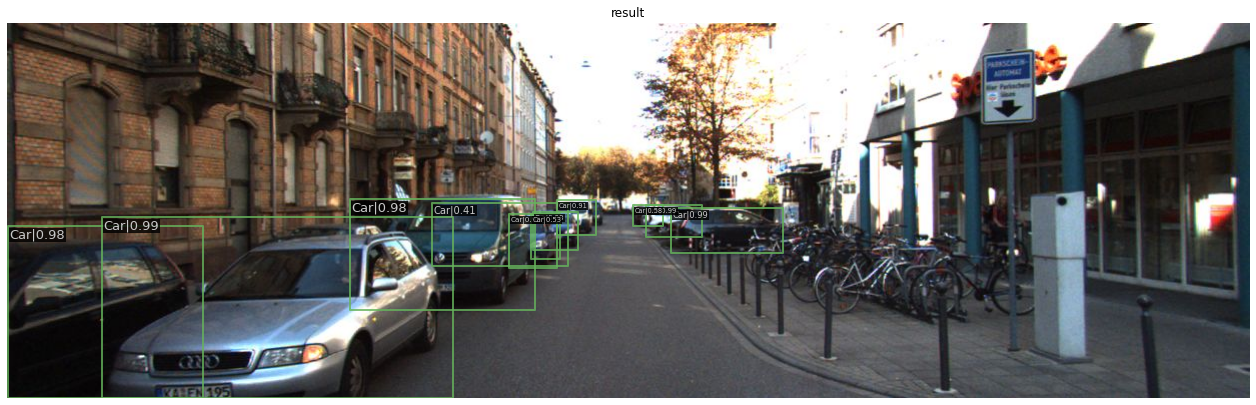

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

new_config = 'updated_config.py'
checkpoint_file = '/content/mmdetection/tutorial_exps/latest.pth'

model = init_detector(new_config, checkpoint_file, device='cuda:0')

img = cv2.imread('/content/kitti_tiny/training/image_2/000068.jpeg')
result = inference_detector(model, img)
show_result_pyplot(model, img, result)

In [59]:
cfg.data.test.pipeline[0].type

'LoadImageFromWebcam'

### 학습된 모델을 이용하여 Video Detection 수행하기
이전 시간에 했던 video inference와 거의 바뀌는거 없음. 다만 CLASSES만 바꿔줌

In [5]:
%cd /content
!mkdir /content/data
!wget -O /content/data/the_rock_chase.mp4 https://github.com/chulminkw/DLCV/blob/master/data/video/the_rock_chase.mp4?raw=true

/content
mkdir: cannot create directory ‘/content/data’: File exists
--2022-05-05 12:10:33--  https://github.com/chulminkw/DLCV/blob/master/data/video/the_rock_chase.mp4?raw=true
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/chulminkw/DLCV/raw/master/data/video/the_rock_chase.mp4 [following]
--2022-05-05 12:10:34--  https://github.com/chulminkw/DLCV/raw/master/data/video/the_rock_chase.mp4
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/the_rock_chase.mp4 [following]
--2022-05-05 12:10:34--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/the_rock_chase.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to ra

In [6]:
# 위와는 반대로 index주면 class 이름 반환
CLASSES = ('Car', 'Truck', 'Pedestrian', 'Cyclist')
labels_to_names_seq = {i:k for i, k in enumerate(CLASSES)}
labels_to_names_seq

{0: 'Car', 1: 'Truck', 2: 'Pedestrian', 3: 'Cyclist'}

In [11]:
CLASSES = ('Car', 'Truck', 'Pedestrian', 'Cyclist')
cat2label = {k:i for i, k in enumerate(CLASSES)}

def get_detected_img(model, img_array,  score_threshold=0.3, is_print=True):
  # 인자로 들어온 image_array를 복사. 
  draw_img = img_array.copy()
  bbox_color=(0, 255, 0)
  text_color=(0, 0, 255)

  # model과 image array를 입력 인자로 inference detection 수행하고 결과를 results로 받음. 
  # results는 80개의 2차원 array(shape=(오브젝트갯수, 5))를 가지는 list. 
  results = inference_detector(model, img_array)

  # 80개의 array원소를 가지는 results 리스트를 loop를 돌면서 개별 2차원 array들을 추출하고 이를 기반으로 이미지 시각화 
  # results 리스트의 위치 index가 바로 COCO 매핑된 Class id. 여기서는 result_ind가 class id
  # 개별 2차원 array에 오브젝트별 좌표와 class confidence score 값을 가짐. 
  for result_ind, result in enumerate(results):
    # 개별 2차원 array의 row size가 0 이면 해당 Class id로 값이 없으므로 다음 loop로 진행. 
    if len(result) == 0:
      continue
    
    # 2차원 array에서 5번째 컬럼에 해당하는 값이 score threshold이며 이 값이 함수 인자로 들어온 score_threshold 보다 낮은 경우는 제외. 
    result_filtered = result[np.where(result[:, 4] > score_threshold)]
    
    # 해당 클래스 별로 Detect된 여러개의 오브젝트 정보가 2차원 array에 담겨 있으며, 이 2차원 array를 row수만큼 iteration해서 개별 오브젝트의 좌표값 추출. 
    for i in range(len(result_filtered)):
      # 좌상단, 우하단 좌표 추출. 
      left = int(result_filtered[i, 0])
      top = int(result_filtered[i, 1])
      right = int(result_filtered[i, 2])
      bottom = int(result_filtered[i, 3])
      caption = "{}: {:.4f}".format(labels_to_names_seq[result_ind], result_filtered[i, 4])
      cv2.rectangle(draw_img, (left, top), (right, bottom), color=bbox_color, thickness=2)
      cv2.putText(draw_img, caption, (int(left), int(top - 7)), cv2.FONT_HERSHEY_SIMPLEX, 0.37, text_color, 1)
      if is_print:
        print(caption)

  return draw_img

In [12]:
import time

def do_detected_video(model, input_path, output_path, score_threshold, do_print=True):
    
    cap = cv2.VideoCapture(input_path)

    codec = cv2.VideoWriter_fourcc(*'XVID')

    vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    vid_fps = cap.get(cv2.CAP_PROP_FPS)

    vid_writer = cv2.VideoWriter(output_path, codec, vid_fps, vid_size) 

    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print('총 Frame 갯수:', frame_cnt)
    btime = time.time()
    while True:
        hasFrame, img_frame = cap.read()
        if not hasFrame:
            print('더 이상 처리할 frame이 없습니다.')
            break
        stime = time.time()
        img_frame = get_detected_img(model, img_frame,  score_threshold=score_threshold, is_print=False)
        if do_print:
          print('frame별 detection 수행 시간:', round(time.time() - stime, 4))
        vid_writer.write(img_frame)
    # end of while loop

    vid_writer.release()
    cap.release()

    print('최종 detection 완료 수행 시간:', round(time.time() - btime, 4))

In [13]:
do_detected_video(model, '/content/data/the_rock_chase.mp4', '/content/data/the_rock_chase_out1.mp4', score_threshold=0.4, do_print=True)

총 Frame 갯수: 503
frame별 detection 수행 시간: 0.3359
frame별 detection 수행 시간: 0.3112
frame별 detection 수행 시간: 0.3085
frame별 detection 수행 시간: 0.3077
frame별 detection 수행 시간: 0.3039
frame별 detection 수행 시간: 0.3031
frame별 detection 수행 시간: 0.3053
frame별 detection 수행 시간: 0.3035
frame별 detection 수행 시간: 0.3055
frame별 detection 수행 시간: 0.3072
frame별 detection 수행 시간: 0.3426
frame별 detection 수행 시간: 0.3347
frame별 detection 수행 시간: 0.3136
frame별 detection 수행 시간: 0.3417
frame별 detection 수행 시간: 0.3051
frame별 detection 수행 시간: 0.309
frame별 detection 수행 시간: 0.2994
frame별 detection 수행 시간: 0.3045
frame별 detection 수행 시간: 0.3029
frame별 detection 수행 시간: 0.2916
frame별 detection 수행 시간: 0.297
frame별 detection 수행 시간: 0.298
frame별 detection 수행 시간: 0.3014
frame별 detection 수행 시간: 0.3046
frame별 detection 수행 시간: 0.2968
frame별 detection 수행 시간: 0.3057
frame별 detection 수행 시간: 0.3071
frame별 detection 수행 시간: 0.3024
frame별 detection 수행 시간: 0.2928
frame별 detection 수행 시간: 0.2971
frame별 detection 수행 시간: 0.2966
frame별 detection 수행 시간: 0.

KeyboardInterrupt: ignored